In [1]:
from comet_ml import Experiment
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from math import ceil
from pathlib import Path
import matplotlib.pyplot as plt
import os
from warnings import warn

from data_loader import AudioFeaturesDataset

start_comet_experiment = True
comet_key = 'ZlzwlR1D1Q0gPpgd2jbz4ywTM'

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print('warning: using cpu!')

def weighted_binary_cross_entropy(output, target, weights=None):
    """
    weights = [w0, w1]
    w0 - znormalizowana liczba elementów klasy 0
    w1 - znormalizowana liczba elementów klasy 1
    """
    if weights is not None:
        assert len(weights) == 2
        
        loss = weights[1] * (target * torch.log(output)) + \
               weights[0] * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

    return torch.neg(torch.mean(loss))

In [3]:
# example model from https://arxiv.org/pdf/1610.00087.pdf (patrz torchaudio tutorial)
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=8, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = x.squeeze()
        return torch.sigmoid(x)

In [5]:
hparams = {
    'audio_path': './data/Processed',
    'observations_path': './data/audio_observations_v3.csv',
    'model_path': './models/m1',
    'version': 'question_only',  # 'question_only' or 'squash_to_one_class' or 'multilabel'
    'batch_size': 128,
    'default_sample_rate': 22050,
    'frame_length':  int(22050 *  10),
    'window_length': int(22050 *  10),
    'hop_length':    int(22050 *  10),
    'seed': 42,
    'test_size': 0.1,
    'use_raw_audio': True,
    'n_mfcc': -1,
    'n_mfcc_hop_length': -1,
    'lr': 0.0001,
    'wdecay': 0.0,
    'beta0': 0.9,
    'beta1': 0.999,
    'use_all_files': True,
    'selected_files_train': [
        '17S2-MH1804-LEC_20180412.mp4.wav',
        '16S2-MH1301-LEC_20170109.mp4.wav',
        '16S2-MH1301-LEC_20170116.mp4.wav',
        '16S2-MH1301-LEC_20170206.mp4.wav',
        '16S2-MH1301-LEC_20170123.mp4.wav',
    ],
    'selected_files_val': [
        '16S2-MH1301-LEC_20170213.mp4.wav',
    ]
}

def get_weights():
    
    def _all_conditions_match(conditions):
        for feature, value in mapping['conditions'].items():
            if hparams[feature] != value:
                return False
        return True
    
    known_mappings = [
        {
            'conditions':
            {
                'frame_length': 220500,
                'window_length': 220500,
                'hop_length': 220500,
                'default_sample_rate': 22050,
                'version': 'question_only'
            },
            'weights': [61579., 7131.]
        }
    ]
    for mapping in known_mappings:
        if _all_conditions_match(mapping['conditions']):
            w = np.array(mapping['weights'])
            return 2 * w / np.sum(w)
    warn('Unknown weights, returning uniform distribution')
    return [1., 1.]
        
weights = get_weights()

if hparams['version'] not in ['question_only', 'squash_to_one_class', 'multilabel']:
    raise RuntimeError('Unknown version!')

hparams['loss'] = weighted_binary_cross_entropy if hparams['version'] in ['question_only', 'squash_to_one_class'] \
    else nn.BCEWithLogitsLoss()
hparams['n_outputs'] = 8 if hparams['version'] == 'multilabel' else 1

torch.manual_seed(hparams['seed'])
torch.cuda.manual_seed(hparams['seed'])
np.random.seed(hparams['seed'])
if not hparams['use_all_files']:
    filelist_train = hparams['selected_files_train']
    filelist_val = hparams['selected_files_val']
else:
    # Just to print all errors should they occur
    AudioFeaturesDataset(hparams['audio_path'], hparams['observations_path'], hparams['batch_size'],
                         hparams['frame_length'], hparams['hop_length'], hparams['window_length'],
                         use_raw_audio=hparams['use_raw_audio'], n_mfcc=hparams['n_mfcc'], device=device,
                         n_mfcc_hop_length=hparams['n_mfcc_hop_length'])
    
    filelist = [file for file in os.listdir(hparams['audio_path']) if file.endswith('.wav')]
    filelist_train, filelist_val = train_test_split(filelist, test_size=hparams['test_size'], random_state=hparams['seed'])

train_dataset = AudioFeaturesDataset(hparams['audio_path'], hparams['observations_path'], hparams['batch_size'],
                                     hparams['frame_length'], hparams['hop_length'], hparams['window_length'],
                                     use_raw_audio=hparams['use_raw_audio'], n_mfcc=hparams['n_mfcc'], device=device,
                                     n_mfcc_hop_length=hparams['n_mfcc_hop_length'], selected_videos=filelist_train)

val_dataset = AudioFeaturesDataset(hparams['audio_path'], hparams['observations_path'], hparams['batch_size'],
                                   hparams['frame_length'], hparams['hop_length'], hparams['window_length'],
                                   use_raw_audio=hparams['use_raw_audio'], n_mfcc=hparams['n_mfcc'], device=device,
                                   n_mfcc_hop_length=hparams['n_mfcc_hop_length'], selected_videos=filelist_val)

/home/jjasek/ntu-video-analysis/data_loader.py:99: UserWarning: No annotations found for file PH1011-PHYSICS_20150929.mp4.wav. It will NOT be added to the training data.
  warn(f'No annotations found for file {filename}. It will NOT be added to the training data.')
/home/jjasek/ntu-video-analysis/data_loader.py:99: UserWarning: No annotations found for file 17S2-BS1102-LEC_20180116.mp4.wav. It will NOT be added to the training data.
  warn(f'No annotations found for file {filename}. It will NOT be added to the training data.')
/home/jjasek/ntu-video-analysis/data_loader.py:99: UserWarning: No annotations found for file 16S2-MH1402-LEC_20170317.mp4.wav. It will NOT be added to the training data.
  warn(f'No annotations found for file {filename}. It will NOT be added to the training data.')
/home/jjasek/ntu-video-analysis/data_loader.py:99: UserWarning: No annotations found for file 17S2-CM1041-LEC_20180209.mp4.wav. It will NOT be added to the training data.
  warn(f'No annotations found

/home/jjasek/ntu-video-analysis/data_loader.py:99: UserWarning: No annotations found for file 18S1-PH1801-LEC_20180824.mp4.wav. It will NOT be added to the training data.
  warn(f'No annotations found for file {filename}. It will NOT be added to the training data.')
/home/jjasek/ntu-video-analysis/data_loader.py:99: UserWarning: No annotations found for file 18S1-PH1801-LEC_20180817.mp4.wav. It will NOT be added to the training data.
  warn(f'No annotations found for file {filename}. It will NOT be added to the training data.')
/home/jjasek/ntu-video-analysis/data_loader.py:99: UserWarning: No annotations found for file 18S1-BS1101-LEC_20181010.mp4.wav. It will NOT be added to the training data.
  warn(f'No annotations found for file {filename}. It will NOT be added to the training data.')
/home/jjasek/ntu-video-analysis/data_loader.py:99: UserWarning: No annotations found for file 18S1-BS1101-LEC_20181023.mp4.wav. It will NOT be added to the training data.
  warn(f'No annotations foun

In [8]:
if os.path.exists(hparams['model_path']):
    print('Loading saved model')
    model = torch.load(hparams['model_path']).to(device)
else:
    model = M5(n_output=hparams['n_outputs']).to(device)
opt = torch.optim.Adam(model.parameters())
loss = weighted_binary_cross_entropy
train_batch_loss = []
val_batch_loss = []
train_loss = []
val_loss = []

name = f"f{int(hparams['use_raw_audio'])}_f{hparams['frame_length']}_w{hparams['window_length']}"\
       f"_h{hparams['hop_length']}_{hparams['model_path'].split('/')[-1]}"
if start_comet_experiment:
    experiment = Experiment(project_name='magisterka', api_key=comet_key, auto_metric_logging=False)
    experiment.log_parameters(hparams)
    experiment.set_model_graph(model)
    experiment.set_name(name)

Loading saved model


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/yuseqyaseq/magisterka/e875c197bd654d33952543d12f8195a3



In [9]:
epochs = 10
max_x = 700
min_x = -700

early_break_train = -1
early_break_val = -1

def preprocess(x, y, device, use_raw_audio):
    if hparams['version'] == 'question_only':
        y = y[:, 2]
    elif hparams['version'] == 'squash_to_one_class':
        y = y.bool().any(axis=1)
    elif hparams['version'] == 'multilabel':
        pass
    else:
        raise RuntimeError('Unknown version')
    x = (x - min_x) / (max_x - min_x)
    if use_raw_audio:
        batch_size, w = x.shape
        x = x.reshape(batch_size, 1, w)
    else:
        batch_size, w, h = x.shape
        x = x.reshape(batch_size, 1, w, h)
    x, y = x.to(device).float(), y.to(device).float()
    return x, y

# w_count count occurences of each label to set correct weights in loss function
if hparams['version'] == 'multilabel':
    w_count = [0 for _ in range(9)]
else:
    w_count = [0, 0]
    
def train():
    sum_loss = 0
    count = 0
    for i, (x, y) in enumerate(tqdm(train_dataset)):
        x, y = preprocess(x, y, device, hparams['use_raw_audio'])
        pred = model(x)
        
        if hparams['version'] in ['question_only', 'squash_to_one_class']:
            #weight = [y.sum(), len(y) - y.sum()]
            #l = loss(pred, y, weights=weight)
            l = loss(pred, y, weights=weights)
            
            w_count[0] += len(y)
            w_count[1] += y.sum(axis=0).detach().cpu().tolist()
        else:
            l = loss(pred, y)
            
            for i in range(1, len(w_count)):
                w_count[i] += class_sum[i - 1]
        
        opt.zero_grad()
        l.backward()
        opt.step()
        
        l = l.detach().cpu().tolist()
        train_batch_loss.append(l)
        sum_loss += l * len(y)
        count += len(y)
        if start_comet_experiment:
            experiment.log_metric('batch_loss', l)
        if i == early_break_train:
            break
    train_loss.append(sum_loss / count)

            
def val():
    sum_loss = 0
    count = 0
    for i, (x, y) in enumerate(tqdm(val_dataset)):
        with torch.no_grad():
            x, y = preprocess(x, y, device, hparams['use_raw_audio'])
            pred = model(x)
            
            if hparams['version'] in ['question_only', 'squash_to_one_class']:
                #weight = [y.sum(), len(y) - y.sum()]
                #l = loss(pred, y, weights=weight)
                l = loss(pred, y, weights=weights)
            else:
                l = loss(pred, y)
            
            l = l.cpu().tolist()
            val_batch_loss.append(l)
            sum_loss += l * len(y)
            count += len(y)
            if start_comet_experiment:
                experiment.log_metric('batch_loss', l)
            if i == early_break_val:
                break
    val_loss.append(sum_loss / count)
            

for e in range(epochs):
    if start_comet_experiment:
        with experiment.train():
            train()
            experiment.log_metric('loss', train_loss[-1])
            
        torch.cuda.empty_cache()
        with experiment.validate():
            val()
            experiment.log_metric('loss', val_loss[-1])
    else:
        train()
        torch.cuda.empty_cache()
        val()
    print(f'epoch: {e}; train loss: {train_loss[-1]}; val_loss: {val_loss[-1]}')
    torch.save(model, f"{hparams['model_path']}_epoch{e}.pt")
    

587it [07:37,  1.28it/s]
48it [00:38,  1.25it/s]


epoch: 0; train loss: 0.12184702160049082; val_loss: 0.11337319958828769


587it [07:23,  1.32it/s]
48it [00:33,  1.42it/s]
0it [00:00, ?it/s]

epoch: 1; train loss: 0.11135324134439606; val_loss: 0.11225840875766754


587it [07:15,  1.35it/s]
48it [00:36,  1.33it/s]
0it [00:00, ?it/s]

epoch: 2; train loss: 0.11097048191829981; val_loss: 0.11281612958037655


587it [07:15,  1.35it/s]
48it [00:36,  1.33it/s]
0it [00:00, ?it/s]

epoch: 3; train loss: 0.10935830417599283; val_loss: 0.11168105639346022


587it [07:28,  1.31it/s]
48it [00:37,  1.28it/s]
0it [00:00, ?it/s]

epoch: 4; train loss: 0.10842460232613067; val_loss: 0.11216838771005132


587it [07:23,  1.32it/s]
48it [00:34,  1.38it/s]
0it [00:00, ?it/s]

epoch: 5; train loss: 0.10835964077884351; val_loss: 0.11214462571699821


587it [07:23,  1.32it/s]
48it [00:34,  1.40it/s]
0it [00:00, ?it/s]

epoch: 6; train loss: 0.11035324293886802; val_loss: 0.11434716869177874


587it [07:24,  1.32it/s]
48it [00:32,  1.49it/s]
0it [00:00, ?it/s]

epoch: 7; train loss: 0.10951474247499081; val_loss: 0.11521935900300473


587it [07:25,  1.32it/s]
48it [00:31,  1.50it/s]
0it [00:00, ?it/s]

epoch: 8; train loss: 0.10808722299793622; val_loss: 0.11181061680345056


587it [07:31,  1.30it/s]
48it [00:33,  1.43it/s]

epoch: 9; train loss: 0.10782750835931605; val_loss: 0.11073216586785167


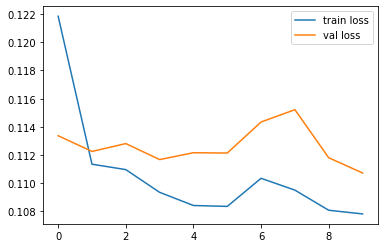

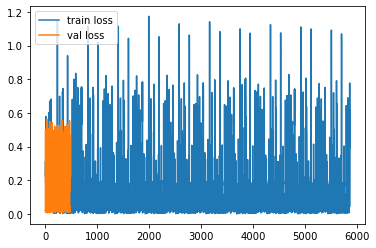

In [10]:
plt.plot(train_loss[:], label='train loss')
plt.plot(val_loss[:], label='val loss')
plt.legend()
plt.show()

plt.plot(train_batch_loss[:], label='train loss')
plt.plot(val_batch_loss[:], label='val loss')
plt.legend()
plt.show()

In [11]:
torch.save(model, hparams['model_path'])

In [23]:
def get_preds():
    preds = []
    actual = []
    for i, (x, y) in enumerate(tqdm(train_dataset)):
        with torch.no_grad():
            x, y = preprocess(x, y, device, hparams['use_raw_audio'])
            pred = model(x)
            pred = pred.squeeze().detach().cpu()
            preds.append(pred)
            actual.append(y)
        if i == early_break_val:
            break
    return torch.cat(preds).type(torch.float32), torch.cat(actual).type(torch.float32)

pred, actual = get_preds()

587it [06:59,  1.40it/s]


In [24]:
threshold = 0.5
preds_ = pred >= threshold
actual = actual.squeeze()
if hparams['version'] == 'multilabel':
    pass
else:
    true_positive = torch.sum(preds_[actual == 1])
    false_positive = torch.sum(preds_[actual == 0])
    true_negative = torch.sum(~preds_[actual == 0])
    false_negative = torch.sum(~preds_[actual == 1])

    print(f'TP = {true_positive}')
    print(f'TN = {true_negative}')
    print(f'FP = {false_positive}')
    print(f'FN = {false_negative}')

    accuracy = (true_positive + true_negative).float() / (true_positive + true_negative + false_positive + false_negative).float()
    p = true_positive.float() / (true_positive + false_positive)
    r = true_positive.float() / (true_positive + false_negative)
    f1_score = 2 * (p * r) / (p + r)
    print(f'accuracy = {accuracy}')
    print(f'precision = {p}')
    print(f'recall = {r}')
    print(f'f1 score = {f1_score}')
    if start_comet_experiment:
                experiment.log_metric('accuracy', accuracy)
                experiment.log_metric('precision', p)
                experiment.log_metric('recall', r)
                experiment.log_metric('f1 score', f1_score)

TP = 24
TN = 61537
FP = 42
FN = 7107
accuracy = 0.8959540128707886
precision = 0.3636363744735718
recall = 0.0033655869774520397
f1 score = 0.0066694458946585655


In [25]:
actual.sum()

tensor(7131., device='cuda:0')

In [26]:
(1 - actual).sum()

tensor(61579., device='cuda:0')

In [ ]:
#class Dataset:
#    def __init__(self, x, y, batch_size, shuffle=True):
#        self.x = x
#        self.y = y
#        self.batch_size = batch_size
#        self.shuffle = shuffle
#        if not shuffle:
#            self.idx = torch.arange(len(self.y))
#        
#        assert len(self.x) == len(self.y)
#    
#    def __iter__(self):
#        if self.shuffle:
#            self.idx = torch.randperm(len(self.y))
#        
#        for i in range(len(self)):
#            yield self.x[self.idx[i*self.batch_size:(i+1)*self.batch_size]],\
#                  self.y[self.idx[i*self.batch_size:(i+1)*self.batch_size]]
#                    
#    def __len__(self):
#        return ceil(len(self.y) / self.batch_size)

#with open(self.path, "rb") as f:
#    while True:
#        try:
#            yield pickle.load(f)
#        except EOFError:
#            break

#path = 'data/features_mfcc.pt'
#x, y = [], []
#dataset = Dataset(path, length=934)
#for data in tqdm(dataset):
#    x.append(data['x'])
#    y.append(data['y'])

#path = './data/data2.pt'
#data = torch.load(path)
#x_train = data['x']
#y_train = data['y']
#x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)
#del data

#train_dataset = Dataset(x_train, y_train, shuffle=True, batch_size=512)
#val_dataset = Dataset(x_train, y_train, shuffle=True, batch_size=512)
#max_x = -1000000
#min_x = 1000000
#for x, y in tqdm(train_dataset):
#    t = x.max()
#    t2 = x.min()
#    if t > max_x:
#        max_x = t.tolist()
#    if t2 < min_x:
#        min_x = t2.tolist()

# for normalization
#max_x, min_x